In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 

In [2]:
# Load data
df = pd.read_csv("CarPrice_Assignment.csv")
df = df[["enginesize", "horsepower", "price"]]
df.head()

,enginesize,horsepower,price
0,130,111,13495.0
1,130,111,16500.0
2,152,154,16500.0
3,109,102,13950.0
4,136,115,17450.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   enginesize  205 non-null    int64  
 1   horsepower  205 non-null    int64  
 2   price       205 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 4.9 KB


In [4]:
class multipleLinearRegression:
 
 def __init__(self):
  self.B_0 = None
  self.B_1 = None
  self.B_2 = None

 def fit(self, x, y):
  
  self.X = np.c_[np.ones((x.shape[0],1)), x]
  self.y = np.array(y)
  self.n = len(y)

  self.XT = self.X.T
  self.XT_X_INVERSE = np.linalg.inv(np.dot(self.XT,self.X))
  self.XT_y = np.dot(self.XT,self.y)

  self.B_hat = np.dot(self.XT_X_INVERSE, self.XT_y)

  self.B_0 = self.B_hat[0]
  self.B_1 = self.B_hat[1]
  self.B_2 = self.B_hat[2]


  self.SSE = np.dot(self.y.T,self.y)-np.dot(self.B_hat.T,self.XT_y)
  self.SST = np.dot(self.y.T,self.y)-(self.n*y.mean()**2)
  self.SSR = self.SST-self.SSE

 def predict(self, x):

  if self.B_0 is None or self.B_1 is None or self.B_2 is None:
   raise ValueError("The model has not been fitted yet.")
  
  X = np.c_[np.ones((x.shape[0], 1)), x]
  predicted_values = np.dot(X , self.B_hat)
  return predicted_values
 
 def plot(self, x, y):
  if self.B_0 is None or self.B_1 is None or self.B_2 is None:
   raise ValueError("The model has not been fitted yet.")
  
  X = np.array(x)
  Y = np.array(y)

  if X.shape[1] !=2 :
   raise ValueError("Ploting is only available for models with exactly two independent variables.")
  
  x1_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 50)
  x2_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 50)

  x1_grid, x2_grid = np.meshgrid(x1_range,x2_range)

  y_pred_grid = self.B_0 + self.B_1*x1_grid + self.B_2*x2_grid

  fig = plt.figure(figsize=(10,7))
  ax = fig.add_subplot(111,projection='3d')

  ax.scatter(X[:, 0], X[:, 1],Y,color='blue',label='DATA POINTS')

  ax.plot_surface(x1_grid, x2_grid, y_pred_grid, color='red', alpha=0.5)

  ax.set_xlabel("feature 1")
  ax.set_ylabel("feature 2")
  ax.set_zlabel("target variable")
  ax.set_title("multiple linear regression - regression plane")
  plt.legend()
  plt.show()

 def anova_table(self):
  if self.B_0 is None or self.B_1 is None or self.B_2 is None:
   raise ValueError("The model has not been fitted yet.")
  
  self.df_regression = 2
  self.df_error = self.n - 3
  df_total = self.n - 1

  MSR = self.SSR / self.df_regression
  MSE = self.SSE / self.df_error

  self.F_stat = MSR / MSE
  anova_data = {
    'Source': ['Regression', 'Error', 'Total'],
    'Sum of Squares': [self.SSR, self.SSE, self.SST],
    'Degrees of Freedom': [self.df_regression, self.df_error, df_total],
    'Mean Square': [MSR, MSE, ""],
    'F-Statistic': [self.F_stat, "", ""]
   }
 
  anova_table = pd.DataFrame(anova_data)
  return anova_table
 
 def hypothesis_test(self, alpha=0.05):
  F_c = scipy.stats.f.ppf(1 - alpha, self.df_regression, self.df_error)

  if self.F_stat > F_c:
   conclusion = ("Since F_0 > F_c, we reject the null hypothesis.\n" "Therefore, there's a relationship between x andy.")
  else:
   conclusion = ("Since F_c > F_0, we don't reject the null hypothesis.\n""Therefore, there's no relationship between x andy.")

  print("="*45)
  print(" Hypothesis Testing Results ")
  print("="*45)
  print(f"{'Null Hypothesis (H_0):':<25} B_1 = 0")
  print(f"{'Alternative Hypothesis (H_a):':<25} B_1 ≠ 0")
  print("-"*45)
  print(f"{'F-statistic (F_0):':<25} {self.F_stat:.4f}")
  print(f"{'Critical value (F_c):':<25} {F_c:.4f}")
  print("-"*45)
  print(f"{conclusion}")
  print("="*45)

 def interval_estimation(self, alpha=0.05, sigma=None):
    if self.B_0 is None or self.B_1 is None or self.B_2 is None:
        raise ValueError("The model has not been fitted yet.")

    if sigma is None:
        t = scipy.stats.t.ppf(1 - (alpha / 2), self.df_error)
        MSE = self.SSE / self.df_error
        cov_matrix = self.XT_X_INVERSE * MSE
    else:
        t = scipy.stats.norm.ppf(1 - (alpha / 2))
        cov_matrix = self.XT_X_INVERSE * (sigma ** 2)

    se_B0 = np.sqrt(cov_matrix[0, 0])
    se_B1 = np.sqrt(cov_matrix[1, 1])
    se_B2 = np.sqrt(cov_matrix[2, 2])

    B_0_interval = [float(self.B_0 - t * se_B0),float(self.B_0 + t * se_B0)]
    B_1_interval = [float(self.B_1 - t * se_B1), float(self.B_1 + t * se_B1)]
    B_2_interval = [float(self.B_2 - t * se_B2), float(self.B_2 + t * se_B2)]

    B_interval=[B_0_interval,B_1_interval,B_2_interval]

    return B_interval
  

In [5]:
features = ['enginesize', 'horsepower']
x = df[features].values
y = df['price'].values
model = multipleLinearRegression()
model.fit(x, y)

In [6]:
print("Evaluation of the model")
print("------------------------")
print(f'Line of best fit is: y = {round(model.B_0,2)} + {round(model.B_1,
2)} x1 + {round(model.B_2, 2)} x2')

Evaluation of the model
------------------------
Line of best fit is: y = -8389.73 + 122.45 x1 + 58.85 x2


In [7]:
y_pred=model.predict(x)
df['price (predicted)'] = y_pred
df.head(7)

,enginesize,horsepower,price,price (predicted)
0,130,111,13495.0,14060.442866
1,130,111,16500.0,14060.442866
2,152,154,16500.0,19284.716363
3,109,102,13950.0,10959.428724
4,136,115,17450.0,15030.514652
5,136,110,15250.0,14736.277543
6,136,110,17710.0,14736.277543


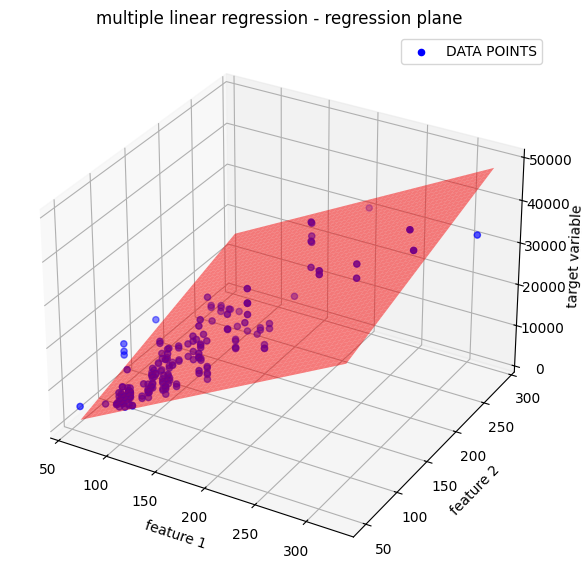

In [8]:
model.plot(x,y)

In [9]:
model.anova_table()

,Source,Sum of Squares,Degrees of Freedom,Mean Square,F-Statistic
0,Regression,1.032901e+10,2,5164505462.946117,387.727302
1,Error,2.690628e+09,202,13319942.752975,
2,Total,1.301964e+10,204,,


In [10]:
model.hypothesis_test()

 Hypothesis Testing Results 
Null Hypothesis (H_0):    B_1 = 0
Alternative Hypothesis (H_a): B_1 ≠ 0
---------------------------------------------
F-statistic (F_0):        387.7273
Critical value (F_c):     3.0406
---------------------------------------------
Since F_0 > F_c, we reject the null hypothesis.
Therefore, there's a relationship between x andy.


In [11]:
B_intervals = model.interval_estimation()
print(f"95% CI for B_0: {B_intervals[0]}")
print(f"95% CI for B_1: {B_intervals[1]}")
print(f"95% CI for B_2: {B_intervals[2]}")

95% CI for B_0: [-10011.583810246306, -6767.882368383464]
95% CI for B_1: [101.82635494771827, 143.06767803830553]
95% CI for B_2: [37.132464586202396, 80.56237885714103]
